QUIC数据集：QUIC数据集 在加州大学戴维斯分校被捕获。 它包含5个谷歌服务的QUIC流量：
谷歌Doc(1251 流 量 ） 、 谷 歌 Drive(1664 流 量 ） 、 谷 歌Music(622流量）、YouTube(1107流量），谷歌搜索（1945年流）。 
数据集包含时间序列特征：
数据包长度、到达时间和方向。划定带宽和持续时间的分类规则进行分类。 数据集已被预处理。 所有少于100个数据包的短流都已删除。 请注意，
数据集中的所有流都有标记。 然而，为了评估我们的多任务学习方法，我们在训练过程中只使用了一小部分类标签。

duration divider，我们首先求出每个class的平均duration。然后，我们对平均值进行排序，然后找到两个连续平均值之间的中点为[d1，…， d4]。例如，在QUIC数据集中，G Music, G Search, G Drive, YouTube, G Doc的平均时长为[2.77,9.83,32.08,56.44,114.10]秒。因此，duration divider为[6.30,20.96,44.26,85.27]。   [bw1, ..., bw4]   [d1, ..., d4]
网络会话的持续时间分为“非常短”，“短”，“长”和“非常长”这四类。

1.数据预处理

这段代码是一个数据处理的脚本。主要实现的功能是从指定文件夹中读取数据，对数据进行预处理，然后将预处理后的数据分为训练集、验证集和测试集，并保存为numpy数组形式的文件。

具体步骤如下：

1.设置了一些全局变量，如数据是否进行插值、长度是否归一化等。

2.定义了一个函数`loadData`，用于读取指定路径下的数据文件，并对数据进行预处理。其中，根据是否设置了抽取样本数，确定每个文件需要抽取的子流数目，然后遍历每个文件，随机抽取指定数目的子流，对子流中的数据进行预处理（如长度离散化、长度归一化、计算时间间隔等），处理后的数据存入datalist中，同时生成label列表，用于表示每个子流对应的标签。

3.在main函数中，依次读取每个文件夹下的数据，将其分割为训练集、验证集和测试集，然后将这些数据组合在一起形成完整的训练集、验证集和测试集，并保存为npy格式的文件。

4.最后打印出分割后的数据形状和标签形状。

总的来说，该脚本实现了对QUIC数据集的预处理，将数据处理成可以输入深度学习模型的形式，以进行后续的训练和预测。

输出数据：1.label列表 `​  temp_label = [Bandwidth, Duration, class_label]  ​`

In [6]:
import pdb
import os
import numpy as np


ComputeInterArrival = True
DescretesizeLength = False
DirectionLengthCombined = True
NormalizeLength = True
NormalizeInterArrival = True
MaxLength = 1434
MaxInterArrival = 1
Starting_point = 0
StartingPointMultiply = 13
Num_of_extracted_subflow = 100
PaddingEnable = True
PadAtTheBegining = True
PaddingThreshold = 20


CompureStatisticsInThisScript = True

NumOfCrossValidationFolds = 1

np.random.seed(10)

timestep = 120
SkipPacketsForSampling = 1
IncrementalSampling = False
NumberOfSamplesUntiIncrement = 10000
IncrementalStepMultiplier = 1 


def loadData(dirPath, class_label,  extractedFlows = 0):  
    #If it is not set, use the global value
    if extractedFlows == 0:
        extractedFlows = Num_of_extracted_subflow

    pathDir = os.listdir(dirPath)

    datalist = []
    labellist = []
    FileCounter = 0
    FlowCounter = 0
    SubflowCounter = 0

    # added by Shahbaz
    custom_features = [
        # 0,    #timestamp
        1,  # RelativeTime
        2,  # length
        # 3    #Direction
    ]

    for folder, subs, files in os.walk(dirPath):

        # if FlowCounter > 1000:
        #     break

        np.random.shuffle(files)

        for file in files:
            filename = folder + "/" + file
            with open(filename) as f:
                
                FileCounter += 1
                
                EntireFile = []
                for line in f:
                    data = line.split()
                    try:
                        EntireFile.append(data)
                    except:
                        print(EntireFile)
                        pdb.set_trace()
                try:
                    EntireFile = np.array(EntireFile).astype(np.float32)    
                except:
                    print(EntireFile)
                    pdb.set_trace()

                FileLenght = len(EntireFile)

                if CompureStatisticsInThisScript:
                    Duration = EntireFile[-1,1]
                    Bandwidth = np.sum(EntireFile[:,2])/Duration
                    temp_label = [Bandwidth, Duration, class_label]

                SubflowFromAFile = 0

                #Skip the fist few packets in the file
                if(Starting_point!=0):
                    for jjj in range(Starting_point):
                        line = f.readline()
                        if not line:
                            break

                for subflow in range(extractedFlows):

                    startingPoint = 0
                    if subflow == 0:
                        startingPoint = 0
                    else:
                        startingPoint = np.random.randint(1, FileLenght-timestep)
                    # startingPoint = Starting_point + subflow*StartingPointMultiply
                    
                    linedata = []
                    Prev_time = 0;  #Time of the first packet in the subflow
    
                    numOfSamples = 0
                    i = startingPoint
                    SkipSamples = SkipPacketsForSampling
                    while(numOfSamples < timestep):
                        if i>=FileLenght:
                            break

                        data = list(EntireFile[i])  #To clone the list, not refering to the same list  
                        
                        #shahbaz: To descretesize the the length
                        if DescretesizeLength:
                            data[2] = str(int(int(data[2])/100))

                        if DirectionLengthCombined:
                            if data[3]=="0":
                                if float(data[2])>0:
                                    data[2] = str(-1 * float(data[2]))
                                    
                        if NormalizeLength:
                            data[2] = str(float(data[2])/MaxLength)
                            
                        if ComputeInterArrival:
                            if i==startingPoint:
                                Prev_time = float(data[1])
                                data[1] = str(0)
                            else:
                                temporary = str(float(data[1]) - Prev_time)
                                Prev_time = float(data[1])
                                data[1] = temporary
                        if NormalizeInterArrival:
                            ttt = float(data[1]) / MaxInterArrival
                            if ttt > 1:
                                ttt=1
                            data[1]=(ttt-0.5)*2
                            

                        try:
                            data2 = [float(data[j]) for j in custom_features]
                        except (IndexError, ValueError) as e:
                            pass
                            print("Couldn't retrieve all data",filename)
                        else:
                            linedata += data2
                
                        numOfSamples += 1 
                        i += SkipSamples
                        if IncrementalSampling:
                            if numOfSamples % NumberOfSamplesUntiIncrement == 0:
                                SkipSamples = int(SkipSamples*IncrementalStepMultiplier)

    
                    if (len(linedata) < len(custom_features) * timestep):
                        if (PaddingThreshold > len(linedata)/len(custom_features) ):
                            continue
                        #print(linedata)
                        if (PaddingEnable):
                            while(len(linedata) < len(custom_features) * timestep):
                                pad = []
                                pad.extend(np.ones(len(custom_features)) * 0)
                                if PadAtTheBegining:
                                    pad.extend(linedata)
                                    linedata = pad
                                else:
                                    linedata.extend(pad)
                            #print(linedata)
                        else:
                            continue
                    np.nan_to_num(linedata)               
                    datalist.append(linedata)                

                    SubflowCounter+=1
                    SubflowFromAFile+=1

                total_labels = [temp_label] * SubflowFromAFile
                labellist.extend(total_labels)
                FlowCounter+=1
                print(filename,temp_label)
    ratio = SubflowCounter/FlowCounter
    print(dirPath + ":" + str(FlowCounter) + "/" + str(len(pathDir)) + " - Subflows:" + str(SubflowCounter) + " - Ratio:", str(ratio))
    return (np.array(datalist), np.array(labellist))  


if __name__ == "__main__":

    BaseDirectory = "D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining"  
    (data1, label1) = loadData(BaseDirectory + "/Google Drive", 1, extractedFlows=1) 
    (data2, label2) = loadData(BaseDirectory + "/Youtube", 2,  extractedFlows=1)
    (data3, label3) = loadData(BaseDirectory + "/Google Doc", 3,  extractedFlows=1)
    (data4, label4) = loadData(BaseDirectory + "/Google Search", 4, extractedFlows=1)
    (data5, label5) = loadData(BaseDirectory + "/Google Music", 5, extractedFlows=1)

    test_size = 30
    val_size = 30
    train1 = data1[:-(test_size+val_size)]
    train2 = data2[:-(test_size+val_size)]
    train3 = data3[:-(test_size+val_size)]
    train4 = data4[:-(test_size+val_size)]
    train5 = data5[:-(test_size+val_size)]
    val1 = data1[-(test_size+val_size):-test_size]
    val2 = data2[-(test_size+val_size):-test_size]
    val3 = data3[-(test_size+val_size):-test_size]
    val4 = data4[-(test_size+val_size):-test_size]
    val5 = data5[-(test_size+val_size):-test_size]
    test1 = data1[-test_size:]
    test2 = data2[-test_size:]
    test3 = data3[-test_size:]
    test4 = data4[-test_size:]
    test5 = data5[-test_size:]

    trainL1 = label1[:-(test_size+val_size)]
    trainL2 = label2[:-(test_size+val_size)]
    trainL3 = label3[:-(test_size+val_size)]
    trainL4 = label4[:-(test_size+val_size)]
    trainL5 = label5[:-(test_size+val_size)]
    valL1 = label1[-(test_size+val_size):-test_size]
    valL2 = label2[-(test_size+val_size):-test_size]
    valL3 = label3[-(test_size+val_size):-test_size]
    valL4 = label4[-(test_size+val_size):-test_size]
    valL5 = label5[-(test_size+val_size):-test_size]
    testL1 = label1[-test_size:]
    testL2 = label2[-test_size:]
    testL3 = label3[-test_size:]
    testL4 = label4[-test_size:]
    testL5 = label5[-test_size:]

    train_data = np.concatenate((train1, train2, train3, train4, train5), axis=0)
    val_data = np.concatenate((val1, val2, val3, val4, val5), axis=0)
    test_data = np.concatenate((test1, test2, test3, test4, test5), axis=0)

    train_label = np.concatenate((trainL1, trainL2, trainL3, trainL4, trainL5), axis=0)
    val_label = np.concatenate((valL1, valL2, valL3, valL4, valL5), axis=0)
    test_label = np.concatenate((testL1, testL2, testL3, testL4, testL5), axis=0)

    np.save("trainData.npy", train_data)
    np.save("trainLabel.npy", train_label)

    np.save("valData.npy", val_data)
    np.save("valLabel.npy", val_label)

    np.save("testData.npy", test_data)
    np.save("testLabel.npy", test_label)                                                                                                                                                                                                                                             

    print(train_data.shape, train_label.shape)
    print(val_data.shape, val_label.shape)
    print(test_data.shape, test_label.shape)


D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-880.txt [220048.98, 37.024, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-887.txt [503086.22, 20.3855, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-1289.txt [7154622.5, 1.99624, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-799.txt [207715.73, 57.3708, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-652.txt [179626.12, 63.3517, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-474.txt [477795.34, 23.2818, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-560.txt [1038574.6, 12.3213, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-1173.txt [149803.83, 59.4123, 1]
D:\研究生学习资料\流量数据集\QUIC Dataset\pretraining\pretraining/Google Drive/GoogleDrive-505.txt [460215.47, 19.5301, 1]


这个输出是指三组数据集的形状（shape），其中第一列数字表示数据集中样本的个数，第二列数字表示每个样本的特征数。 

对于第一组数据 `(6139, 240) (6139, 3)` ，它包含了两个numpy数组，分别表示训练集和标签集。其中训练集包含了6139个样本，每个样本有240个特征；标签集包含了6139个样本，每个样本有3个标签。

对于第二组数据 `(150, 240) (150, 3)` ，它也包含了两个numpy数组，分别表示验证集和标签集。其中验证集包含了150个样本，每个样本有240个特征；标签集包含了150个样本，每个样本有3个标签。

对于第三组数据 `(150, 240) (150, 3)` ，同样包含了两个numpy数组，分别表示测试集和标签集。其中测试集包含了150个样本，每个样本有240个特征；标签集包含了150个样本，每个样本有3个标签。

2.t-SNE可视化
数据集进行一些处理和可视化
首先，它使用 numpy 的 save 函数将训练、验证和测试数据及其标签保存为 .npy 格式的文件。这使得你能够在其他 Python 脚本或会话中轻松加载和使用这些数据。

然后，它打印出这些数据的形状，以便你能快速检查数据的大小和维度。

接着，它使用 t-SNE (t-Distributed Stochastic Neighbor Embedding) 进行数据的降维处理。t-SNE 是一种非常有效的降维技术，特别适用于将高维数据降低到 2 或 3 维以便进行可视化。在这个过程中，相似的数据点会被映射到降维空间中的接近位置，而不相似的数据点则会被映射到远离的位置。

之后，代码对训练标签进行了归一化处理，将标签转换为了 [0, 1] 范围内的值。这样做的原因可能是为了在后续的散点图中以颜色的方式表示不同的标签类别。

最后，代码使用 matplotlib 创建了一个散点图，其中每个点代表一个数据点，其在图中的位置由 t-SNE 降维的结果决定，颜色由其对应的标签决定。

从这个散点图中，你可以观察到你的数据在降维后的空间布局。如果同一类别的数据点在图中紧密地聚集在一起，那么说明这些数据在原始空间中就很相似。反之，如果同一类别的数据点在图中散布得很开，那么说明这些数据在原始空间中可能存在很大的差异。这种可视化可以帮助你理解你的数据集的复杂性，以及分类任务的难度。

(6139, 240) (6139, 3)
(150, 240) (150, 3)
(150, 240) (150, 3)


C:\Users\yuyongjie\AppData\Local\Temp\ipykernel_16052\2136356303.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(train_data_2d[:, 0], train_data_2d[:, 1], c=normalized_train_label, s=50, cmap='viridis')
d:\文件下载盘\lib\site-packages\matplotlib\collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


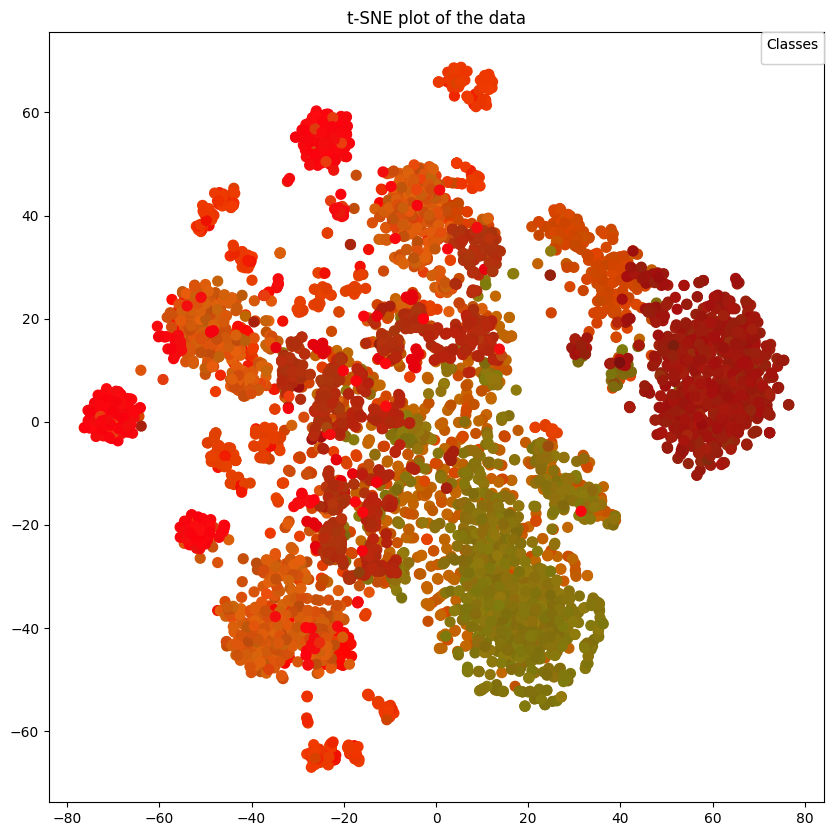

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

if __name__ == "__main__":
    
    # your previous code here...

    np.save("trainData.npy", train_data)
    np.save("trainLabel.npy", train_label)

    np.save("valData.npy", val_data)
    np.save("valLabel.npy", val_label)

    np.save("testData.npy", test_data)
    np.save("testLabel.npy", test_label)

    print(train_data.shape, train_label.shape)
    print(val_data.shape, val_label.shape)
    print(test_data.shape, test_label.shape)

    # Using t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0)
    train_data_2d = tsne.fit_transform(train_data.reshape(len(train_data), -1)) # reshaping data to 2D for t-SNE

    # Normalizing labels
    unique_labels = np.unique(train_label)
    normalized_train_label = np.array([[np.where(unique_labels==i)[0][0] for i in row] for row in train_label])/len(unique_labels)

    # Plotting the results
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(train_data_2d[:, 0], train_data_2d[:, 1], c=normalized_train_label, s=50, cmap='viridis')
    plt.title('t-SNE plot of the data')

    # Adding legend
    # Generate a list of legend elements
    legend1 = plt.legend(*scatter.legend_elements(), 
                        title="Classes",
                        loc="upper right", 
                        borderaxespad=0.)

    # Add legend to the plot
    plt.gca().add_artist(legend1)
    
    plt.show()


对于 t-SNE 可视化图表，有几个关键因素可以帮助你判断分类任务的难度：

聚类清晰度：如果同一类别的数据点在图中形成清晰的、紧密的聚类，并且不同类别的聚类之间有明显的边界，那么这意味着分类任务相对容易。这是因为这种情况下，不同类别的数据在原始空间中有明显的区别。

重叠程度：如果不同类别的数据点在图中大量重叠，那么这意味着分类任务比较困难。这是因为这种情况下，不同类别的数据在原始空间中可能没有明显的区别。

离群点：如果图中存在一些远离任何聚类的数据点（即离群点），那么这可能会增加分类任务的难度。这是因为这种情况下，一些数据在原始空间中可能与大多数数据有很大的差异。

聚类数量和大小：如果类别的数量非常多，或者某些类别的数据量远超其他类别，那么这也可能增加分类任务的难度。这是因为这种情况下，模型可能会过度适应那些数据量较大的类别，而忽略那些数据量较小的类别。

请注意，虽然 t-SNE 可视化可以提供一些有用的洞见，但它也有一些局限性。例如，它可能会过度夸大某些类别之间的差异，或者掩盖某些类别之间的相似性。因此，对 t-SNE 图表的分析应当作为对数据的初步理解，而不是决定模型选择和训练策略的唯一依据。

3.基础cnn

In [13]:
import numpy as np
from keras.models import Model
from keras.layers import Dense
from keras.layers import multiply
from keras.layers import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation
from keras.optimizers import Adam

timestep = 60
np.random.seed(10)

num_class = 5
train_sample_per_class = 20
lambda_value = 1


trainData = np.load("trainData.npy")
trainlabel = np.load("trainLabel.npy")
# trainData = trainData[:, -timestep*2:]
# trainlabel = trainlabel[:, -timestep*2:]
trainData = trainData[:, :timestep*2]
trainlabel = trainlabel[:, :timestep*2]
trainlabel = trainlabel.astype(int)

trainmask = np.zeros((trainlabel.shape[0],256))

class_counter = np.zeros((num_class))
train_size = trainlabel.shape[0]
j = 0
for i in range(train_size):
    class_id = trainlabel[i,2] - 1
    if class_counter[class_id] < train_sample_per_class:
        trainmask[i, :] = 1
        j += 1
        class_counter[class_id] += 1
print("unmasked samples: ", str(np.sum(trainmask==1)/256))


valData = np.load("valData.npy")
valLabel = np.load("valLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
valData = valData[:, :timestep*2]
valLabel = valLabel[:, :timestep*2]

valLabel = valLabel.astype(int)
valmask = np.ones((valLabel.shape[0], 256))
valmask[:,:]=1


testData = np.load("testData.npy")
testLabel = np.load("testLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
testData = testData[:, :timestep*2]
testLabel = testLabel[:, :timestep*2]

testLabel = testLabel.astype(int)
testmask = np.ones((testLabel.shape[0], 256))
testmask[:,:]=1

for i in range(trainlabel.shape[0]):
    #Categorizing Bandwidth
    if trainlabel[i, 0] < 10000:
        trainlabel[i, 0] = 1
    elif trainlabel[i, 0] < 50000:
        trainlabel[i, 0] = 2
    elif trainlabel[i, 0] < 100000:
        trainlabel[i, 0] = 3
    elif trainlabel[i, 0] < 1000000:
        trainlabel[i, 0] = 4
    else:
        trainlabel[i, 0] = 5
    #Categorizing Duration
    if trainlabel[i, 1] < 10:
        trainlabel[i, 1] = 1
    elif trainlabel[i, 1] < 30:
        trainlabel[i, 1] = 2
    elif trainlabel[i, 1] < 60:
        trainlabel[i, 1] = 3
    else:
        trainlabel[i, 1] = 4

for i in range(valLabel.shape[0]):
    #Categorizing Bandwidth
    if valLabel[i, 0] < 10000:
        valLabel[i, 0] = 1
    elif valLabel[i, 0] < 50000:
        valLabel[i, 0] = 2
    elif valLabel[i, 0] < 100000:
        valLabel[i, 0] = 3
    elif valLabel[i, 0] < 1000000:
        valLabel[i, 0] = 4
    else:
        valLabel[i, 0] = 5
    #Categorizing Duration
    if valLabel[i, 1] < 10:
        valLabel[i, 1] = 1
    elif valLabel[i, 1] < 30:
        valLabel[i, 1] = 2
    elif valLabel[i, 1] < 60:
        valLabel[i, 1] = 3
    else:
        valLabel[i, 1] = 4


for i in range(testLabel.shape[0]):
    #Categorizing Bandwidth
    if testLabel[i, 0] < 10000:
        testLabel[i, 0] = 1
    elif testLabel[i, 0] < 50000:
        testLabel[i, 0] = 2
    elif testLabel[i, 0] < 100000:
        testLabel[i, 0] = 3
    elif testLabel[i, 0] < 1000000:
        testLabel[i, 0] = 4
    else:
        testLabel[i, 0] = 5
    #Categorizing Duration
    if testLabel[i, 1] < 10:
        testLabel[i, 1] = 1
    elif testLabel[i, 1] < 30:
        testLabel[i, 1] = 2
    elif testLabel[i, 1] < 60:
        testLabel[i, 1] = 3
    else:
        testLabel[i, 1] = 4


train_size = trainlabel.shape[0]
Y_train1 = np.zeros((train_size,5))
Y_train1[np.arange(train_size),trainlabel[:,0]-1] = 1
Y_train2 = np.zeros((train_size,4))
Y_train2[np.arange(train_size),trainlabel[:,1]-1] = 1
Y_train3 = np.zeros((train_size,5))
Y_train3[np.arange(train_size),trainlabel[:,2]-1] = 1

val_size = valLabel.shape[0]
Y_val1 = np.zeros((val_size,5))
Y_val1[np.arange(val_size),valLabel[:,0]-1] = 1
Y_val2 = np.zeros((val_size,4))
Y_val2[np.arange(val_size),valLabel[:,1]-1] = 1
Y_val3 = np.zeros((val_size,5))
Y_val3[np.arange(val_size),valLabel[:,2]-1] = 1

test_size = testLabel.shape[0]
Y_test1 = np.zeros((test_size,5))
Y_test1[np.arange(test_size),testLabel[:,0]-1] = 1
Y_test2 = np.zeros((test_size,4))
Y_test2[np.arange(test_size),testLabel[:,1]-1] = 1
Y_test3 = np.zeros((test_size,5))
Y_test3[np.arange(test_size),testLabel[:,2]-1] = 1

# trainData = np.expand_dims(trainData, axis=-1)
# testData = np.expand_dims(testData, axis=-1)
trainData = trainData.reshape((trainData.shape[0], timestep, 2))
testData = testData.reshape((testData.shape[0], timestep, 2))
valData = valData.reshape((valData.shape[0], timestep, 2))

def base_model():

    model_input = Input(shape=(timestep,2))
    mask_input = Input(shape=(256,))

    x = Conv1D(32, 3, activation='relu')(model_input)
    x = Conv1D(32, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Conv1D(64, 3, activation='relu')(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Conv1D(128, 3, activation='relu')(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Flatten()(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)

    output1 = Dense(5, activation='softmax', name='Bandwidth')(x)

    output2 = Dense(4, activation='softmax', name='Duration')(x)

    x3 = multiply([x,mask_input])
    output3 = Dense(5, activation='softmax', name='Class')(x3)

    model = Model(inputs=[model_input,mask_input], outputs=[output1, output2, output3])
    opt = Adam(clipnorm = 1.)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1,1,lambda_value], optimizer=opt, metrics=['accuracy'])

    return model

model = base_model()

model.fit([trainData,trainmask], [Y_train1, Y_train2, Y_train3],
          validation_data = ([valData, valmask], [Y_val1, Y_val2, Y_val3]),
          batch_size = 64, epochs = 20, verbose = True, shuffle = True)

result = model.evaluate([testData, testmask], [Y_test1, Y_test2, Y_test3])
print(result)


unmasked samples:  100.0
Epoch 1/20
96/96 [==============================] - 2s 13ms/step - loss: 3.7073 - Bandwidth_loss: 1.0412 - Duration_loss: 1.0706 - Class_loss: 1.5955 - Bandwidth_accuracy: 0.5797 - Duration_accuracy: 0.5366 - Class_accuracy: 0.2917 - val_loss: 3.1883 - val_Bandwidth_loss: 0.9434 - val_Duration_loss: 0.9914 - val_Class_loss: 1.2536 - val_Bandwidth_accuracy: 0.5600 - val_Duration_accuracy: 0.5267 - val_Class_accuracy: 0.3933
Epoch 2/20
96/96 [==============================] - 1s 10ms/step - loss: 3.0399 - Bandwidth_loss: 0.6985 - Duration_loss: 0.7703 - Class_loss: 1.5711 - Bandwidth_accuracy: 0.6944 - Duration_accuracy: 0.6858 - Class_accuracy: 0.3064 - val_loss: 2.6409 - val_Bandwidth_loss: 0.8102 - val_Duration_loss: 0.8296 - val_Class_loss: 1.0012 - val_Bandwidth_accuracy: 0.6867 - val_Duration_accuracy: 0.7267 - val_Class_accuracy: 0.6200
Epoch 3/20
96/96 [==============================] - 1s 10ms/step - loss: 2.7674 - Bandwidth_loss: 0.5674 - Duration_loss:

5/5 [==============================] - 0s 2ms/step
Classification Report for Bandwidth:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        30
           1     1.0000    0.9630    0.9811        27
           2     0.7500    1.0000    0.8571         3
           3     0.8621    0.9804    0.9174        51
           4     0.9688    0.7949    0.8732        39

    accuracy                         0.9333       150
   macro avg     0.9162    0.9476    0.9258       150
weighted avg     0.9400    0.9333    0.9327       150



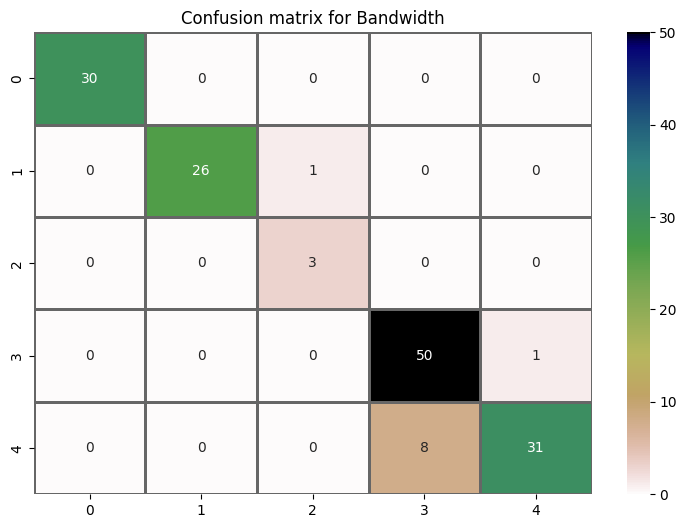

Classification Report for Duration:
              precision    recall  f1-score   support

           0     0.9355    0.6304    0.7532        46
           1     0.7273    0.9143    0.8101        35
           2     0.5143    0.7826    0.6207        23
           3     0.8500    0.7391    0.7907        46

    accuracy                         0.7533       150
   macro avg     0.7568    0.7666    0.7437       150
weighted avg     0.7961    0.7533    0.7577       150



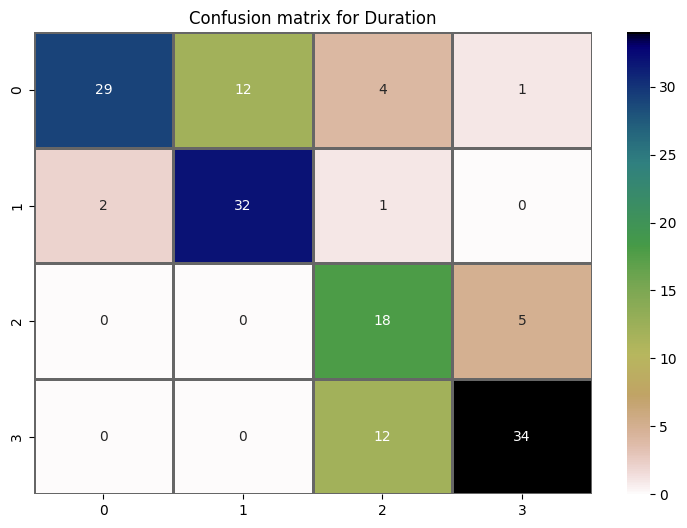

Classification Report for Class:
              precision    recall  f1-score   support

           0     0.9355    0.9667    0.9508        30
           1     0.8000    0.9333    0.8615        30
           2     1.0000    1.0000    1.0000        30
           3     1.0000    1.0000    1.0000        30
           4     1.0000    0.8000    0.8889        30

    accuracy                         0.9400       150
   macro avg     0.9471    0.9400    0.9402       150
weighted avg     0.9471    0.9400    0.9402       150



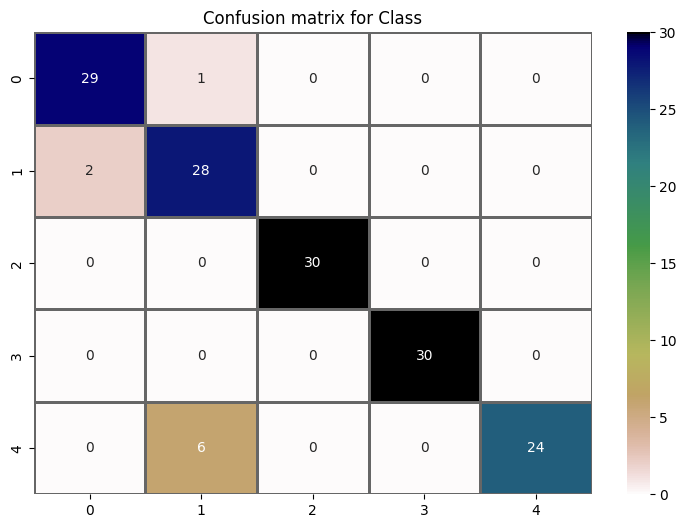

In [14]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# 对测试数据进行预测
pred = model.predict([testData, testmask])

# 计算每个输出的精度、召回率、F1得分和支持，并绘制混淆矩阵
outputs = ['Bandwidth', 'Duration', 'Class']
true_labels = [Y_test1, Y_test2, Y_test3]
for i in range(3):
    # 获取预测的标签
    predicted = np.argmax(pred[i], axis=1)
    expected = np.argmax(true_labels[i], axis=1)
    
    # 打印指标
    print(f'Classification Report for {outputs[i]}:')
    print(classification_report(expected, predicted, digits=4))

    # 绘制混淆矩阵
    cm = metrics.confusion_matrix(expected, predicted)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='0.6g', linewidths=1, cmap='gist_earth_r', linecolor='#666666')
    plt.title(f'Confusion matrix for {outputs[i]}')
    plt.show()

这是一个分类报告，它显示了你的模型在各个类别上的性能。这里有五个类别，分别编号为0到4。下面是各列的含义：

precision：精确度，也就是预测为某个类别并且预测正确的比例。
recall：召回率，也就是实际为某个类别并且被预测正确的比例。
f1-score：F1得分，是精确度和召回率的调和平均数，用于同时考虑精确度和召回率的评价指标。
support：该类别在测试集中的实例数量。
此外：

accuracy：模型正确预测的总体比例。
macro avg：所有类别的平均精确度、召回率和F1得分，没有考虑各类别的实例数量（即每个类别的重要性相同）。
weighted avg：所有类别的平均精确度、召回率和F1得分，但是这个平均是根据各类别的实例数量加权的（即数量多的类别更重要）。
以下是每个指标的含义：

准确率（Precision）：对于每一个类别，准确率是模型预测为该类别并且预测正确的实例数（True Positives）占模型预测为该类别的所有实例数（True Positives + False Positives）的比例。高准确率表示模型在预测该类别时产生的假阳性（False Positives，实际上是其它类别但被模型错误预测为该类别的实例）较少。

召回率（Recall）：对于每一个类别，召回率是模型预测为该类别并且预测正确的实例数（True Positives）占真实为该类别的所有实例数（True Positives + False Negatives）的比例。高召回率表示模型在预测该类别时漏掉的实例（False Negatives，实际上是该类别但被模型错误预测为其它类别的实例）较少。

F1分数（F1-Score）：F1分数是准确率和召回率的调和平均值，它试图在这两个指标之间找到一个平衡。如果模型的准确率和召回率都很高，那么F1分数也会很高。

支持度（Support）：对于每一个类别，支持度是数据集中属于该类别的实例数。在这个报告中，比如，第0类有30个实例，第1类有27个实例，等等。

“accuracy”是模型的总体正确率，也就是模型预测正确的实例数占总实例数的比例。

“macro avg”是每个指标的宏平均值，它将所有类别的准确率（或召回率/F1分数）相加然后除以类别数，即不考虑每个类别的实例数。

“weighted avg”是每个指标的加权平均值，它将每个类别的准确率（或召回率/F1分数）乘以其支持度（也就是该类别的实例数），然后求和，最后除以总的实例数。

在你的数据中，可以看出类别0、1和4的精确度和召回率都比较高，这意味着模型在这些类别上的预测较为准确。类别3虽然样本数量最多，但其精确度和召回率也相对较高。而类别2的精确度相对较低，可能是由于样本数量较少，模型对该类别的学习不足。

In [1]:
pip install seaborn matplotlib numpy pandas sklearn

ERROR: Exception:
Traceback (most recent call last):
  File "d:\文件下载盘\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in _main
    status = self.run(options, args)
  File "d:\文件下载盘\lib\site-packages\pip\_internal\cli\req_command.py", line 204, in wrapper
    return func(self, options, args)
  File "d:\文件下载盘\lib\site-packages\pip\_internal\commands\install.py", line 318, in run
    requirement_set = resolver.resolve(
  File "d:\文件下载盘\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 127, in resolve
    result = self._result = resolver.resolve(
  File "d:\文件下载盘\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "d:\文件下载盘\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 341, in resolve
    name, crit = self._merge_into_criterion(r, parent=None)
  File "d:\文件下载盘\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 172, in _merge_int

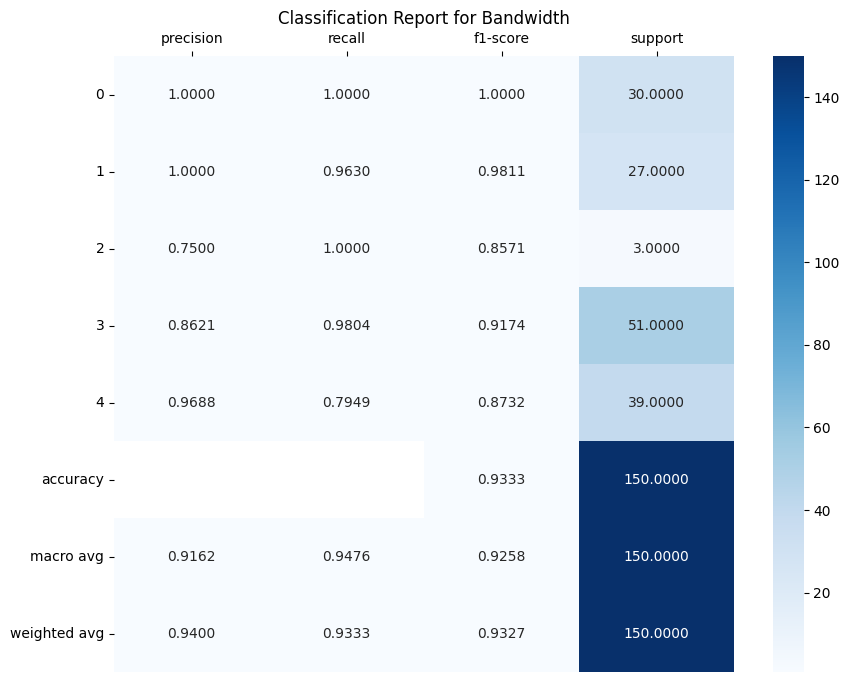

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个DataFrame来存储你的数据
data = {
    'precision': [1.0000, 1.0000, 0.7500, 0.8621, 0.9688, np.nan, 0.9162, 0.9400],
    'recall': [1.0000, 0.9630, 1.0000, 0.9804, 0.7949, np.nan, 0.9476, 0.9333],
    'f1-score': [1.0000, 0.9811, 0.8571, 0.9174, 0.8732, 0.9333, 0.9258, 0.9327],
    'support': [30, 27, 3, 51, 39, 150, 150, 150]
}
df = pd.DataFrame(data, index=['0', '1', '2', '3', '4', 'accuracy', 'macro avg', 'weighted avg'])

# 创建一个热力图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".4f", cmap='Blues')
ax.xaxis.tick_top()  # 将x轴标签放在图形顶部
plt.title("Classification Report for Bandwidth")
plt.show()


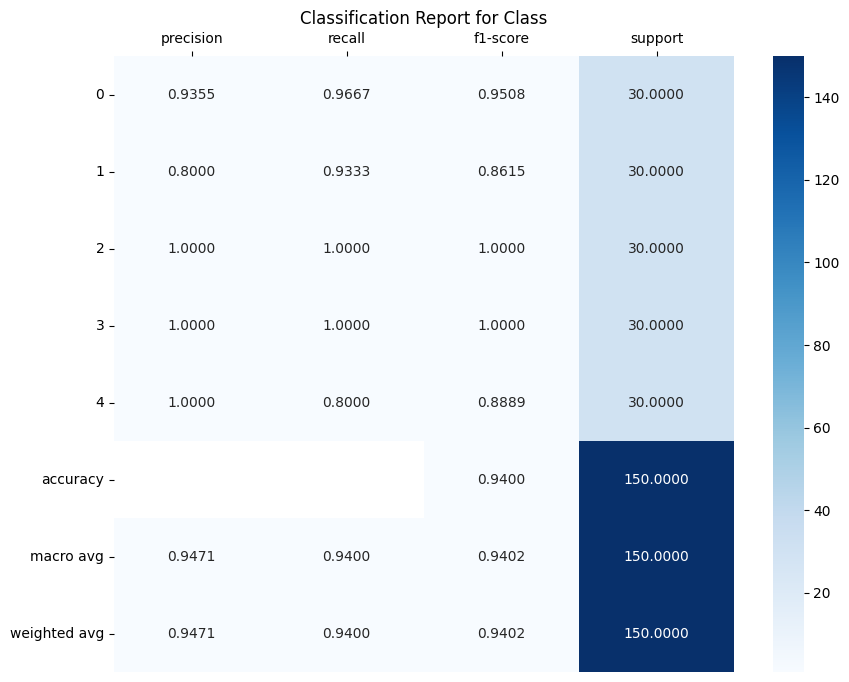

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个DataFrame来存储你的数据
data = {
    'precision': [0.9355, 0.8000, 1.0000, 1.0000, 1.0000, np.nan, 0.9471, 0.9471],
    'recall': [0.9667, 0.9333, 1.0000, 1.0000, 0.8000, np.nan, 0.9400, 0.9400],
    'f1-score': [0.9508, 0.8615, 1.0000, 1.0000, 0.8889, 0.9400, 0.9402, 0.9402],
    'support': [30, 30, 30, 30, 30, 150, 150, 150]
}
df = pd.DataFrame(data, index=['0', '1', '2', '3', '4', 'accuracy', 'macro avg', 'weighted avg'])

# 创建一个热力图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".4f", cmap='Blues')
ax.xaxis.tick_top()  # 将x轴标签放在图形顶部
plt.title("Classification Report for Class")
plt.show()

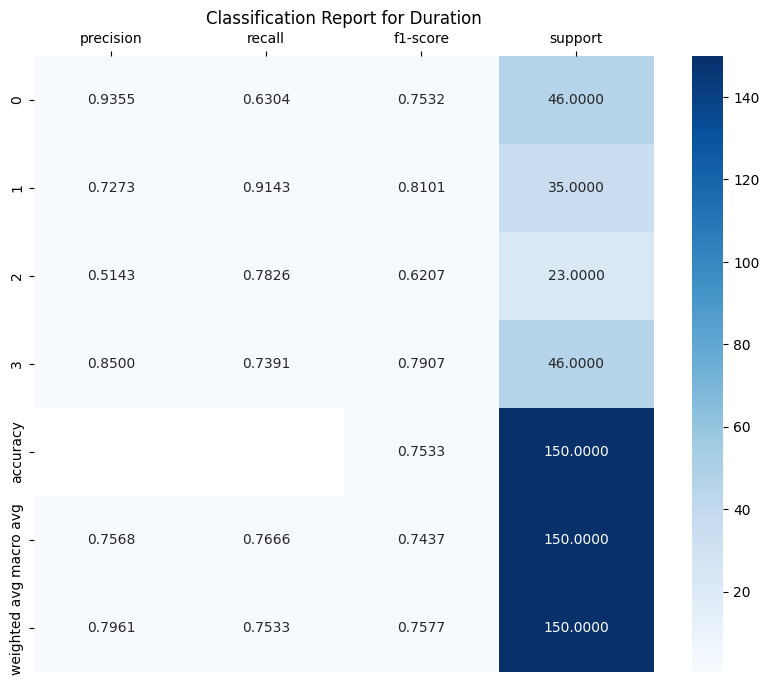

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个DataFrame来存储你的数据
data = {
    'precision': [0.9355, 0.7273, 0.5143, 0.8500, np.nan, 0.7568, 0.7961],
    'recall': [0.6304, 0.9143, 0.7826, 0.7391, np.nan, 0.7666, 0.7533],
    'f1-score': [0.7532, 0.8101, 0.6207, 0.7907, 0.7533, 0.7437, 0.7577],
    'support': [46, 35, 23, 46, 150, 150, 150]
}
df = pd.DataFrame(data, index=['0', '1', '2', '3', 'accuracy', 'macro avg', 'weighted avg'])

# 创建一个热力图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".4f", cmap='Blues')
ax.xaxis.tick_top()  # 将x轴标签放在图形顶部
plt.title("Classification Report for Duration")
plt.show()


4.improve_CNN

In [1]:
"""在优化深度学习模型的过程中，有很多种方法可以尝试，包括调整网络架构、修改损失函数、改变优化器的参数、使用预训练模型、改变训练数据的处理方式等等。以下提供一些可能的优化建议：

使用更复杂的网络架构：更复杂的网络架构可能能够捕捉到更多的数据特征，从而提高模型的性能。例如，可以考虑使用更多的卷积层或者全连接层，或者使用不同类型的层，如循环神经网络（RNN）层
或者自注意力（Self-Attention）层。

修改损失函数或优化器：可以尝试使用不同的损失函数或者优化器，或者改变优化器的参数，如学习率、动量等。

使用预训练模型：如果有可用的预训练模型，可以使用迁移学习的方式，将预训练模型的部分层作为新模型的一部分，只训练剩余的层。

改变数据处理方式：可以尝试对数据进行不同的预处理操作，如归一化、标准化等。此外，也可以使用数据增强的方式增加训练数据的多样性。

使用早停（Early Stopping）和模型检查点（Model Checkpoint）：早停可以防止模型过拟合，而模型检查点可以在训练过程中保存性能最好的模型。"""
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Dense
from keras.layers import multiply
from keras.layers import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation
from keras.optimizers import Adam

timestep = 60
np.random.seed(10)

num_class = 5
train_sample_per_class = 20
lambda_value = 1


trainData = np.load("trainData.npy")
trainlabel = np.load("trainLabel.npy")
# trainData = trainData[:, -timestep*2:]
# trainlabel = trainlabel[:, -timestep*2:]
trainData = trainData[:, :timestep*2]
trainlabel = trainlabel[:, :timestep*2]
trainlabel = trainlabel.astype(int)

trainmask = np.zeros((trainlabel.shape[0],256))

class_counter = np.zeros((num_class))
train_size = trainlabel.shape[0]
j = 0
for i in range(train_size):
    class_id = trainlabel[i,2] - 1
    if class_counter[class_id] < train_sample_per_class:
        trainmask[i, :] = 1
        j += 1
        class_counter[class_id] += 1
print("unmasked samples: ", str(np.sum(trainmask==1)/256))


valData = np.load("valData.npy")
valLabel = np.load("valLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
valData = valData[:, :timestep*2]
valLabel = valLabel[:, :timestep*2]

valLabel = valLabel.astype(int)
valmask = np.ones((valLabel.shape[0], 256))
valmask[:,:]=1


testData = np.load("testData.npy")
testLabel = np.load("testLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
testData = testData[:, :timestep*2]
testLabel = testLabel[:, :timestep*2]

testLabel = testLabel.astype(int)
testmask = np.ones((testLabel.shape[0], 256))
testmask[:,:]=1

for i in range(trainlabel.shape[0]):
    #Categorizing Bandwidth
    if trainlabel[i, 0] < 10000:
        trainlabel[i, 0] = 1
    elif trainlabel[i, 0] < 50000:
        trainlabel[i, 0] = 2
    elif trainlabel[i, 0] < 100000:
        trainlabel[i, 0] = 3
    elif trainlabel[i, 0] < 1000000:
        trainlabel[i, 0] = 4
    else:
        trainlabel[i, 0] = 5
    #Categorizing Duration
    if trainlabel[i, 1] < 10:
        trainlabel[i, 1] = 1
    elif trainlabel[i, 1] < 30:
        trainlabel[i, 1] = 2
    elif trainlabel[i, 1] < 60:
        trainlabel[i, 1] = 3
    else:
        trainlabel[i, 1] = 4

for i in range(valLabel.shape[0]):
    #Categorizing Bandwidth
    if valLabel[i, 0] < 10000:
        valLabel[i, 0] = 1
    elif valLabel[i, 0] < 50000:
        valLabel[i, 0] = 2
    elif valLabel[i, 0] < 100000:
        valLabel[i, 0] = 3
    elif valLabel[i, 0] < 1000000:
        valLabel[i, 0] = 4
    else:
        valLabel[i, 0] = 5
    #Categorizing Duration
    if valLabel[i, 1] < 10:
        valLabel[i, 1] = 1
    elif valLabel[i, 1] < 30:
        valLabel[i, 1] = 2
    elif valLabel[i, 1] < 60:
        valLabel[i, 1] = 3
    else:
        valLabel[i, 1] = 4


for i in range(testLabel.shape[0]):
    #Categorizing Bandwidth
    if testLabel[i, 0] < 10000:
        testLabel[i, 0] = 1
    elif testLabel[i, 0] < 50000:
        testLabel[i, 0] = 2
    elif testLabel[i, 0] < 100000:
        testLabel[i, 0] = 3
    elif testLabel[i, 0] < 1000000:
        testLabel[i, 0] = 4
    else:
        testLabel[i, 0] = 5
    #Categorizing Duration
    if testLabel[i, 1] < 10:
        testLabel[i, 1] = 1
    elif testLabel[i, 1] < 30:
        testLabel[i, 1] = 2
    elif testLabel[i, 1] < 60:
        testLabel[i, 1] = 3
    else:
        testLabel[i, 1] = 4


train_size = trainlabel.shape[0]
Y_train1 = np.zeros((train_size,5))
Y_train1[np.arange(train_size),trainlabel[:,0]-1] = 1
Y_train2 = np.zeros((train_size,4))
Y_train2[np.arange(train_size),trainlabel[:,1]-1] = 1
Y_train3 = np.zeros((train_size,5))
Y_train3[np.arange(train_size),trainlabel[:,2]-1] = 1

val_size = valLabel.shape[0]
Y_val1 = np.zeros((val_size,5))
Y_val1[np.arange(val_size),valLabel[:,0]-1] = 1
Y_val2 = np.zeros((val_size,4))
Y_val2[np.arange(val_size),valLabel[:,1]-1] = 1
Y_val3 = np.zeros((val_size,5))
Y_val3[np.arange(val_size),valLabel[:,2]-1] = 1

test_size = testLabel.shape[0]
Y_test1 = np.zeros((test_size,5))
Y_test1[np.arange(test_size),testLabel[:,0]-1] = 1
Y_test2 = np.zeros((test_size,4))
Y_test2[np.arange(test_size),testLabel[:,1]-1] = 1
Y_test3 = np.zeros((test_size,5))
Y_test3[np.arange(test_size),testLabel[:,2]-1] = 1

# trainData = np.expand_dims(trainData, axis=-1)
# testData = np.expand_dims(testData, axis=-1)
trainData = trainData.reshape((trainData.shape[0], timestep, 2))
testData = testData.reshape((testData.shape[0], timestep, 2))
valData = valData.reshape((valData.shape[0], timestep, 2))


def improved_model():

    model_input = Input(shape=(timestep,2))
    mask_input = Input(shape=(256,))

    x = Conv1D(32, 3, activation='relu')(model_input)
    x = Conv1D(32, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Conv1D(64, 3, activation='relu')(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Conv1D(128, 3, activation='relu')(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Flatten()(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)

    output1 = Dense(5, activation='softmax', name='Bandwidth')(x)

    output2 = Dense(4, activation='softmax', name='Duration')(x)

    x3 = multiply([x,mask_input])
    output3 = Dense(5, activation='softmax', name='Class')(x3)

    model = Model(inputs=[model_input,mask_input], outputs=[output1, output2, output3])
    opt = Adam(clipnorm = 1.)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1,1,lambda_value], optimizer=opt, metrics=['accuracy'])

    return model

model = improved_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.fit([trainData,trainmask], [Y_train1, Y_train2, Y_train3],
          validation_data = ([valData, valmask], [Y_val1, Y_val2, Y_val3]),
          batch_size = 64, epochs = 20, verbose = True, shuffle = True,
          callbacks=[early_stopping, model_checkpoint])

result = model.evaluate([testData, testmask], [Y_test1, Y_test2, Y_test3])
print(result)

unmasked samples:  100.0
Epoch 1/20
96/96 [==============================] - 2s 13ms/step - loss: 3.7388 - Bandwidth_loss: 1.0520 - Duration_loss: 1.0890 - Class_loss: 1.5977 - Bandwidth_accuracy: 0.5561 - Duration_accuracy: 0.5156 - Class_accuracy: 0.3004 - val_loss: 3.6193 - val_Bandwidth_loss: 1.2232 - val_Duration_loss: 1.0578 - val_Class_loss: 1.3383 - val_Bandwidth_accuracy: 0.5200 - val_Duration_accuracy: 0.5533 - val_Class_accuracy: 0.4400
Epoch 2/20
96/96 [==============================] - 1s 9ms/step - loss: 2.9847 - Bandwidth_loss: 0.6664 - Duration_loss: 0.7458 - Class_loss: 1.5725 - Bandwidth_accuracy: 0.7087 - Duration_accuracy: 0.6899 - Class_accuracy: 0.3072 - val_loss: 2.6344 - val_Bandwidth_loss: 0.7466 - val_Duration_loss: 0.8381 - val_Class_loss: 1.0497 - val_Bandwidth_accuracy: 0.7133 - val_Duration_accuracy: 0.7333 - val_Class_accuracy: 0.4800
Epoch 3/20
96/96 [==============================] - 1s 9ms/step - loss: 2.6788 - Bandwidth_loss: 0.5237 - Duration_loss: 0

5/5 [==============================] - 0s 2ms/step
Classification Report for Bandwidth:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        30
           1     0.9000    1.0000    0.9474        27
           2     0.0000    0.0000    0.0000         3
           3     0.8621    0.9804    0.9174        51
           4     0.9688    0.7949    0.8732        39

    accuracy                         0.9200       150
   macro avg     0.7462    0.7551    0.7476       150
weighted avg     0.9070    0.9200    0.9095       150



d:\文件下载盘\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文件下载盘\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文件下载盘\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


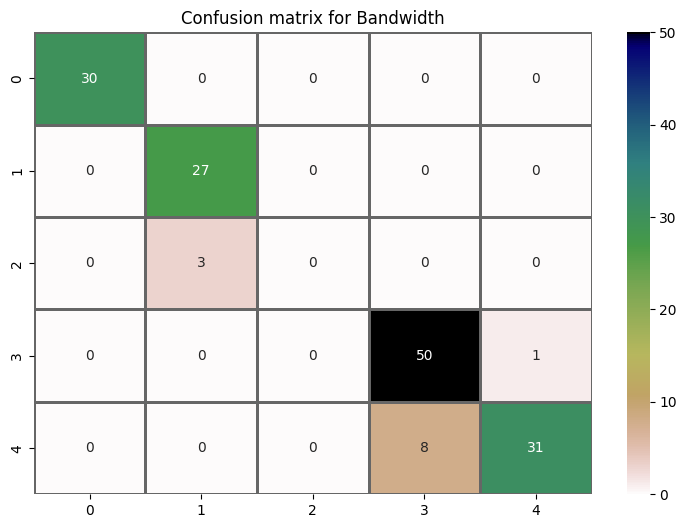

Classification Report for Duration:
              precision    recall  f1-score   support

           0     0.7647    0.8478    0.8041        46
           1     0.9167    0.6286    0.7458        35
           2     0.5250    0.9130    0.6667        23
           3     0.9429    0.7174    0.8148        46

    accuracy                         0.7667       150
   macro avg     0.7873    0.7767    0.7578       150
weighted avg     0.8180    0.7667    0.7727       150



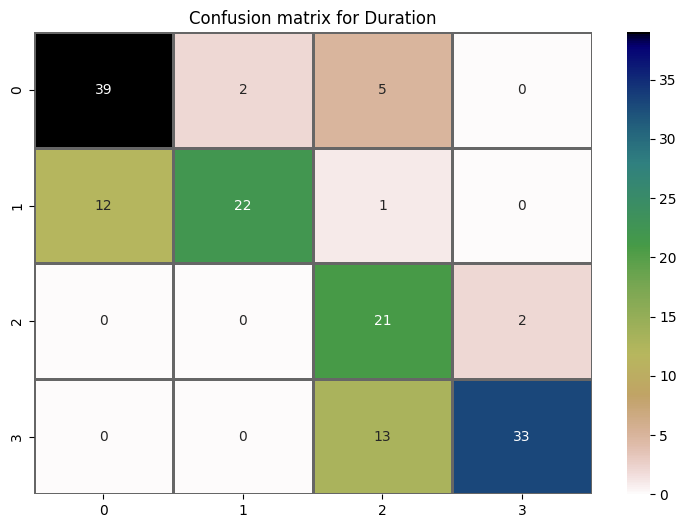

Classification Report for Class:
              precision    recall  f1-score   support

           0     0.9167    0.7333    0.8148        30
           1     0.7568    0.9333    0.8358        30
           2     1.0000    1.0000    1.0000        30
           3     1.0000    1.0000    1.0000        30
           4     0.8621    0.8333    0.8475        30

    accuracy                         0.9000       150
   macro avg     0.9071    0.9000    0.8996       150
weighted avg     0.9071    0.9000    0.8996       150



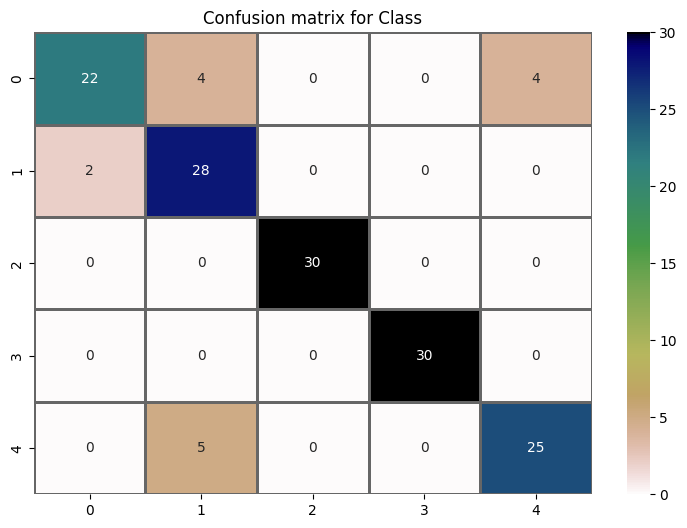

In [2]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# 对测试数据进行预测
pred = model.predict([testData, testmask])

# 计算每个输出的精度、召回率、F1得分和支持，并绘制混淆矩阵
outputs = ['Bandwidth', 'Duration', 'Class']
true_labels = [Y_test1, Y_test2, Y_test3]
for i in range(3):
    # 获取预测的标签
    predicted = np.argmax(pred[i], axis=1)
    expected = np.argmax(true_labels[i], axis=1)
    
    # 打印指标
    print(f'Classification Report for {outputs[i]}:')
    print(classification_report(expected, predicted, digits=4))

    # 绘制混淆矩阵
    cm = metrics.confusion_matrix(expected, predicted)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='0.6g', linewidths=1, cmap='gist_earth_r', linecolor='#666666')
    plt.title(f'Confusion matrix for {outputs[i]}')
    plt.show()


5.SAE

In [3]:
import numpy as np
from keras.layers import Flatten
from tensorflow.keras.layers import Input, Dense, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

timestep = 60
np.random.seed(10)

num_class = 5
train_sample_per_class = 20
lambda_value = 1


trainData = np.load("trainData.npy")
trainlabel = np.load("trainLabel.npy")
# trainData = trainData[:, -timestep*2:]
# trainlabel = trainlabel[:, -timestep*2:]
trainData = trainData[:, :timestep*2]
trainlabel = trainlabel[:, :timestep*2]
trainlabel = trainlabel.astype(int)

trainmask = np.zeros((trainlabel.shape[0],256))

class_counter = np.zeros((num_class))
train_size = trainlabel.shape[0]
j = 0
for i in range(train_size):
    class_id = trainlabel[i,2] - 1
    if class_counter[class_id] < train_sample_per_class:
        trainmask[i, :] = 1
        j += 1
        class_counter[class_id] += 1
print("unmasked samples: ", str(np.sum(trainmask==1)/256))


valData = np.load("valData.npy")
valLabel = np.load("valLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
valData = valData[:, :timestep*2]
valLabel = valLabel[:, :timestep*2]

valLabel = valLabel.astype(int)
valmask = np.ones((valLabel.shape[0], 256))
valmask[:,:]=1


testData = np.load("testData.npy")
testLabel = np.load("testLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
testData = testData[:, :timestep*2]
testLabel = testLabel[:, :timestep*2]

testLabel = testLabel.astype(int)
testmask = np.ones((testLabel.shape[0], 256))
testmask[:,:]=1

for i in range(trainlabel.shape[0]):
    #Categorizing Bandwidth
    if trainlabel[i, 0] < 10000:
        trainlabel[i, 0] = 1
    elif trainlabel[i, 0] < 50000:
        trainlabel[i, 0] = 2
    elif trainlabel[i, 0] < 100000:
        trainlabel[i, 0] = 3
    elif trainlabel[i, 0] < 1000000:
        trainlabel[i, 0] = 4
    else:
        trainlabel[i, 0] = 5
    #Categorizing Duration
    if trainlabel[i, 1] < 10:
        trainlabel[i, 1] = 1
    elif trainlabel[i, 1] < 30:
        trainlabel[i, 1] = 2
    elif trainlabel[i, 1] < 60:
        trainlabel[i, 1] = 3
    else:
        trainlabel[i, 1] = 4

for i in range(valLabel.shape[0]):
    #Categorizing Bandwidth
    if valLabel[i, 0] < 10000:
        valLabel[i, 0] = 1
    elif valLabel[i, 0] < 50000:
        valLabel[i, 0] = 2
    elif valLabel[i, 0] < 100000:
        valLabel[i, 0] = 3
    elif valLabel[i, 0] < 1000000:
        valLabel[i, 0] = 4
    else:
        valLabel[i, 0] = 5
    #Categorizing Duration
    if valLabel[i, 1] < 10:
        valLabel[i, 1] = 1
    elif valLabel[i, 1] < 30:
        valLabel[i, 1] = 2
    elif valLabel[i, 1] < 60:
        valLabel[i, 1] = 3
    else:
        valLabel[i, 1] = 4


for i in range(testLabel.shape[0]):
    #Categorizing Bandwidth
    if testLabel[i, 0] < 10000:
        testLabel[i, 0] = 1
    elif testLabel[i, 0] < 50000:
        testLabel[i, 0] = 2
    elif testLabel[i, 0] < 100000:
        testLabel[i, 0] = 3
    elif testLabel[i, 0] < 1000000:
        testLabel[i, 0] = 4
    else:
        testLabel[i, 0] = 5
    #Categorizing Duration
    if testLabel[i, 1] < 10:
        testLabel[i, 1] = 1
    elif testLabel[i, 1] < 30:
        testLabel[i, 1] = 2
    elif testLabel[i, 1] < 60:
        testLabel[i, 1] = 3
    else:
        testLabel[i, 1] = 4


train_size = trainlabel.shape[0]
Y_train1 = np.zeros((train_size,5))
Y_train1[np.arange(train_size),trainlabel[:,0]-1] = 1
Y_train2 = np.zeros((train_size,4))
Y_train2[np.arange(train_size),trainlabel[:,1]-1] = 1
Y_train3 = np.zeros((train_size,5))
Y_train3[np.arange(train_size),trainlabel[:,2]-1] = 1

val_size = valLabel.shape[0]
Y_val1 = np.zeros((val_size,5))
Y_val1[np.arange(val_size),valLabel[:,0]-1] = 1
Y_val2 = np.zeros((val_size,4))
Y_val2[np.arange(val_size),valLabel[:,1]-1] = 1
Y_val3 = np.zeros((val_size,5))
Y_val3[np.arange(val_size),valLabel[:,2]-1] = 1

test_size = testLabel.shape[0]
Y_test1 = np.zeros((test_size,5))
Y_test1[np.arange(test_size),testLabel[:,0]-1] = 1
Y_test2 = np.zeros((test_size,4))
Y_test2[np.arange(test_size),testLabel[:,1]-1] = 1
Y_test3 = np.zeros((test_size,5))
Y_test3[np.arange(test_size),testLabel[:,2]-1] = 1

# trainData = np.expand_dims(trainData, axis=-1)
# testData = np.expand_dims(testData, axis=-1)
trainData = trainData.reshape((trainData.shape[0], timestep, 2))
testData = testData.reshape((testData.shape[0], timestep, 2))
valData = valData.reshape((valData.shape[0], timestep, 2))

def base_model():
    input_shape = (timestep, 2)
    mask_shape = (256,)

    model_input = Input(shape=input_shape)
    mask_input = Input(shape=mask_shape)

    x = Flatten()(model_input)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    encoded = Dense(32, activation='relu')(x)

    x = Dense(64, activation='relu')(encoded)
    x = Dense(128, activation='relu')(x)
    decoded = Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoded = Reshape(input_shape)(decoded)

    autoencoder = Model(model_input, decoded)

    encoder = Model(model_input, encoded)

    decoder_input = Input(shape=(32,))
    x = Dense(64, activation='relu')(decoder_input)
    x = Dense(128, activation='relu')(x)
    decoded = Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoded = Reshape(input_shape)(decoded)
    decoder = Model(decoder_input, decoded)




    x = Flatten()(encoded)

    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    output1 = Dense(5, activation='softmax', name='Bandwidth')(x)
    output2 = Dense(4, activation='softmax', name='Duration')(x)

    x3 = Multiply()([x, mask_input])
    output3 = Dense(5, activation='softmax', name='Class')(x3)

    model = Model(inputs=[model_input, mask_input], outputs=[output1, output2, output3])
    
    opt = Adam(clipnorm = 1.)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
                  loss_weights=[1, 1, lambda_value], optimizer=opt, metrics=['accuracy'])
    return model

model = base_model()

model.fit([trainData, trainmask], [Y_train1, Y_train2, Y_train3],
          validation_data=([valData, valmask], [Y_val1, Y_val2, Y_val3]),
          batch_size=64, epochs=20, verbose=True, shuffle=True)

result = model.evaluate([testData, testmask], [Y_test1, Y_test2, Y_test3])
print(result)

unmasked samples:  100.0
Epoch 1/20
96/96 [==============================] - 1s 5ms/step - loss: 3.4993 - Bandwidth_loss: 0.9538 - Duration_loss: 0.9481 - Class_loss: 1.5974 - Bandwidth_accuracy: 0.6299 - Duration_accuracy: 0.5950 - Class_accuracy: 0.3030 - val_loss: 2.8324 - val_Bandwidth_loss: 0.7652 - val_Duration_loss: 0.8539 - val_Class_loss: 1.2133 - val_Bandwidth_accuracy: 0.6733 - val_Duration_accuracy: 0.6667 - val_Class_accuracy: 0.6467
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 2.8688 - Bandwidth_loss: 0.6187 - Duration_loss: 0.6819 - Class_loss: 1.5682 - Bandwidth_accuracy: 0.7539 - Duration_accuracy: 0.7239 - Class_accuracy: 0.3110 - val_loss: 2.3269 - val_Bandwidth_loss: 0.6626 - val_Duration_loss: 0.8037 - val_Class_loss: 0.8606 - val_Bandwidth_accuracy: 0.7467 - val_Duration_accuracy: 0.6933 - val_Class_accuracy: 0.7000
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 2.7152 - Bandwidth_loss: 0.5377 - Duration_loss: 0.

5/5 [==============================] - 0s 1ms/step
Classification Report for Bandwidth:
              precision    recall  f1-score   support

           0     1.0000    0.9333    0.9655        30
           1     0.9630    0.9630    0.9630        27
           2     0.6667    0.6667    0.6667         3
           3     0.8136    0.9412    0.8727        51
           4     0.9091    0.7692    0.8333        39

    accuracy                         0.8933       150
   macro avg     0.8705    0.8547    0.8602       150
weighted avg     0.8996    0.8933    0.8932       150



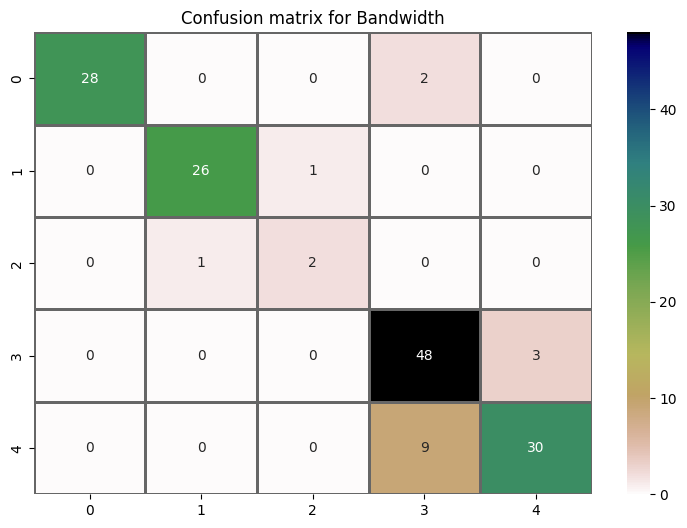

Classification Report for Duration:
              precision    recall  f1-score   support

           0     0.6981    0.8043    0.7475        46
           1     0.8750    0.6000    0.7119        35
           2     0.5556    0.8696    0.6780        23
           3     0.8649    0.6957    0.7711        46

    accuracy                         0.7333       150
   macro avg     0.7484    0.7424    0.7271       150
weighted avg     0.7687    0.7333    0.7357       150



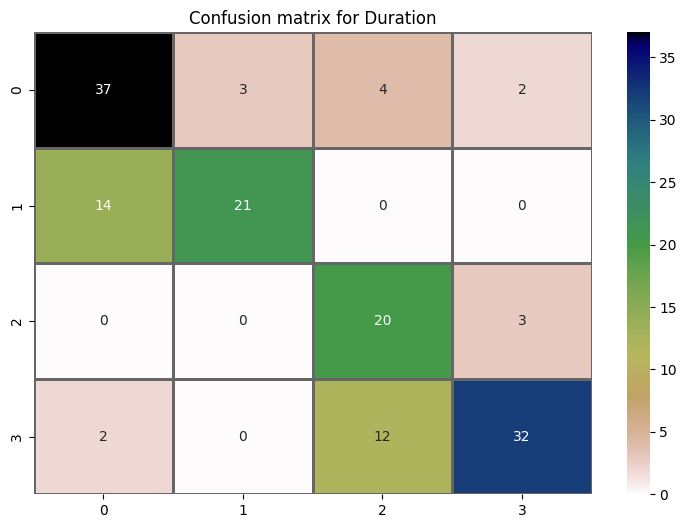

Classification Report for Class:
              precision    recall  f1-score   support

           0     0.9130    0.7000    0.7925        30
           1     0.7436    0.9667    0.8406        30
           2     1.0000    0.9333    0.9655        30
           3     1.0000    1.0000    1.0000        30
           4     0.8333    0.8333    0.8333        30

    accuracy                         0.8867       150
   macro avg     0.8980    0.8867    0.8864       150
weighted avg     0.8980    0.8867    0.8864       150



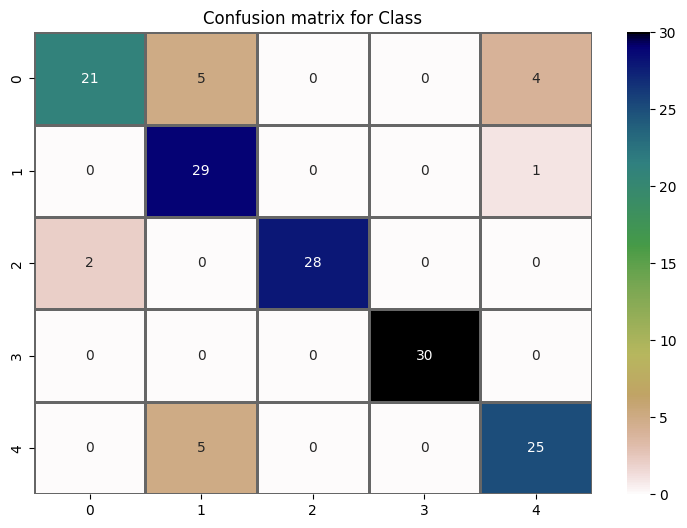

In [19]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# 对测试数据进行预测
pred = model.predict([testData, testmask])

# 计算每个输出的精度、召回率、F1得分和支持，并绘制混淆矩阵
outputs = ['Bandwidth', 'Duration', 'Class']
true_labels = [Y_test1, Y_test2, Y_test3]
for i in range(3):
    # 获取预测的标签
    predicted = np.argmax(pred[i], axis=1)
    expected = np.argmax(true_labels[i], axis=1)
    
    # 打印指标
    print(f'Classification Report for {outputs[i]}:')
    print(classification_report(expected, predicted, digits=4))

    # 绘制混淆矩阵
    cm = metrics.confusion_matrix(expected, predicted)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='0.6g', linewidths=1, cmap='gist_earth_r', linecolor='#666666')
    plt.title(f'Confusion matrix for {outputs[i]}')
    plt.show()


6.GRU

In [15]:
import numpy as np
from keras.models import Model
from keras.layers import Dense
from keras.layers import multiply
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.optimizers import Adam
from keras.layers import GRU

timestep = 60
np.random.seed(10)

num_class = 5
train_sample_per_class = 20
lambda_value = 1


trainData = np.load("trainData.npy")
trainlabel = np.load("trainLabel.npy")
# trainData = trainData[:, -timestep*2:]
# trainlabel = trainlabel[:, -timestep*2:]
trainData = trainData[:, :timestep*2]
trainlabel = trainlabel[:, :timestep*2]
trainlabel = trainlabel.astype(int)

trainmask = np.zeros((trainlabel.shape[0],256))

class_counter = np.zeros((num_class))
train_size = trainlabel.shape[0]
j = 0
for i in range(train_size):
    class_id = trainlabel[i,2] - 1
    if class_counter[class_id] < train_sample_per_class:
        trainmask[i, :] = 1
        j += 1
        class_counter[class_id] += 1
print("unmasked samples: ", str(np.sum(trainmask==1)/256))


valData = np.load("valData.npy")
valLabel = np.load("valLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
valData = valData[:, :timestep*2]
valLabel = valLabel[:, :timestep*2]

valLabel = valLabel.astype(int)
valmask = np.ones((valLabel.shape[0], 256))
valmask[:,:]=1


testData = np.load("testData.npy")
testLabel = np.load("testLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
testData = testData[:, :timestep*2]
testLabel = testLabel[:, :timestep*2]

testLabel = testLabel.astype(int)
testmask = np.ones((testLabel.shape[0], 256))
testmask[:,:]=1

for i in range(trainlabel.shape[0]):
    #Categorizing Bandwidth
    if trainlabel[i, 0] < 10000:
        trainlabel[i, 0] = 1
    elif trainlabel[i, 0] < 50000:
        trainlabel[i, 0] = 2
    elif trainlabel[i, 0] < 100000:
        trainlabel[i, 0] = 3
    elif trainlabel[i, 0] < 1000000:
        trainlabel[i, 0] = 4
    else:
        trainlabel[i, 0] = 5
    #Categorizing Duration
    if trainlabel[i, 1] < 10:
        trainlabel[i, 1] = 1
    elif trainlabel[i, 1] < 30:
        trainlabel[i, 1] = 2
    elif trainlabel[i, 1] < 60:
        trainlabel[i, 1] = 3
    else:
        trainlabel[i, 1] = 4

for i in range(valLabel.shape[0]):
    #Categorizing Bandwidth
    if valLabel[i, 0] < 10000:
        valLabel[i, 0] = 1
    elif valLabel[i, 0] < 50000:
        valLabel[i, 0] = 2
    elif valLabel[i, 0] < 100000:
        valLabel[i, 0] = 3
    elif valLabel[i, 0] < 1000000:
        valLabel[i, 0] = 4
    else:
        valLabel[i, 0] = 5
    #Categorizing Duration
    if valLabel[i, 1] < 10:
        valLabel[i, 1] = 1
    elif valLabel[i, 1] < 30:
        valLabel[i, 1] = 2
    elif valLabel[i, 1] < 60:
        valLabel[i, 1] = 3
    else:
        valLabel[i, 1] = 4


for i in range(testLabel.shape[0]):
    #Categorizing Bandwidth
    if testLabel[i, 0] < 10000:
        testLabel[i, 0] = 1
    elif testLabel[i, 0] < 50000:
        testLabel[i, 0] = 2
    elif testLabel[i, 0] < 100000:
        testLabel[i, 0] = 3
    elif testLabel[i, 0] < 1000000:
        testLabel[i, 0] = 4
    else:
        testLabel[i, 0] = 5
    #Categorizing Duration
    if testLabel[i, 1] < 10:
        testLabel[i, 1] = 1
    elif testLabel[i, 1] < 30:
        testLabel[i, 1] = 2
    elif testLabel[i, 1] < 60:
        testLabel[i, 1] = 3
    else:
        testLabel[i, 1] = 4


train_size = trainlabel.shape[0]
Y_train1 = np.zeros((train_size,5))
Y_train1[np.arange(train_size),trainlabel[:,0]-1] = 1
Y_train2 = np.zeros((train_size,4))
Y_train2[np.arange(train_size),trainlabel[:,1]-1] = 1
Y_train3 = np.zeros((train_size,5))
Y_train3[np.arange(train_size),trainlabel[:,2]-1] = 1

val_size = valLabel.shape[0]
Y_val1 = np.zeros((val_size,5))
Y_val1[np.arange(val_size),valLabel[:,0]-1] = 1
Y_val2 = np.zeros((val_size,4))
Y_val2[np.arange(val_size),valLabel[:,1]-1] = 1
Y_val3 = np.zeros((val_size,5))
Y_val3[np.arange(val_size),valLabel[:,2]-1] = 1

test_size = testLabel.shape[0]
Y_test1 = np.zeros((test_size,5))
Y_test1[np.arange(test_size),testLabel[:,0]-1] = 1
Y_test2 = np.zeros((test_size,4))
Y_test2[np.arange(test_size),testLabel[:,1]-1] = 1
Y_test3 = np.zeros((test_size,5))
Y_test3[np.arange(test_size),testLabel[:,2]-1] = 1

# trainData = np.expand_dims(trainData, axis=-1)
# testData = np.expand_dims(testData, axis=-1)
trainData = trainData.reshape((trainData.shape[0], timestep, 2))
testData = testData.reshape((testData.shape[0], timestep, 2))
valData = valData.reshape((valData.shape[0], timestep, 2))

def base_model():

    model_input = Input(shape=(timestep,2))
    mask_input = Input(shape=(256,))

    x = GRU(32, return_sequences=True)(model_input)
    x = GRU(32, return_sequences=True)(x)

    x = GRU(64, return_sequences=True)(x)
    x = GRU(64, return_sequences=True)(x)

    x = GRU(128, return_sequences=True)(x)
    x = GRU(128)(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)

    output1 = Dense(5, activation='softmax', name='Bandwidth')(x)

    output2 = Dense(4, activation='softmax', name='Duration')(x)

    x3 = multiply([x,mask_input])
    output3 = Dense(5, activation='softmax', name='Class')(x3)

    model = Model(inputs=[model_input,mask_input], outputs=[output1, output2, output3])
    opt = Adam(clipnorm = 1.)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
                  loss_weights=[1,1,lambda_value], optimizer=opt, metrics=['accuracy'])

    return model

model = base_model()

model.fit([trainData,trainmask], [Y_train1, Y_train2, Y_train3],
          validation_data = ([valData, valmask], [Y_val1, Y_val2, Y_val3]),
          batch_size = 64, epochs = 20, verbose = True, shuffle = True)

result = model.evaluate([testData, testmask], [Y_test1, Y_test2, Y_test3])
print(result)

unmasked samples:  100.0
Epoch 1/20
96/96 [==============================] - 19s 142ms/step - loss: 4.1979 - Bandwidth_loss: 1.3044 - Duration_loss: 1.2960 - Class_loss: 1.5975 - Bandwidth_accuracy: 0.4890 - Duration_accuracy: 0.3549 - Class_accuracy: 0.3017 - val_loss: 4.1577 - val_Bandwidth_loss: 1.2942 - val_Duration_loss: 1.3483 - val_Class_loss: 1.5152 - val_Bandwidth_accuracy: 0.4400 - val_Duration_accuracy: 0.3667 - val_Class_accuracy: 0.2867
Epoch 2/20
96/96 [==============================] - 13s 133ms/step - loss: 3.8006 - Bandwidth_loss: 1.0964 - Duration_loss: 1.1271 - Class_loss: 1.5772 - Bandwidth_accuracy: 0.5641 - Duration_accuracy: 0.4906 - Class_accuracy: 0.3049 - val_loss: 3.5601 - val_Bandwidth_loss: 1.0542 - val_Duration_loss: 1.0399 - val_Class_loss: 1.4661 - val_Bandwidth_accuracy: 0.5800 - val_Duration_accuracy: 0.6000 - val_Class_accuracy: 0.3867
Epoch 3/20
96/96 [==============================] - 14s 143ms/step - loss: 3.0637 - Bandwidth_loss: 0.7176 - Duration

5/5 [==============================] - 1s 18ms/step
Classification Report for Bandwidth:
              precision    recall  f1-score   support

           0     1.0000    0.9333    0.9655        30
           1     0.9000    1.0000    0.9474        27
           2     0.0000    0.0000    0.0000         3
           3     0.8103    0.9216    0.8624        51
           4     0.8824    0.7692    0.8219        39

    accuracy                         0.8800       150
   macro avg     0.7185    0.7248    0.7194       150
weighted avg     0.8669    0.8800    0.8705       150



d:\文件下载盘\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文件下载盘\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文件下载盘\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


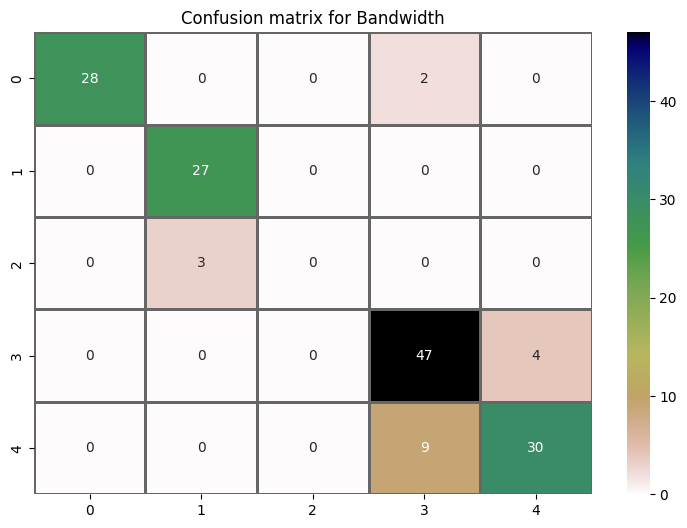

Classification Report for Duration:
              precision    recall  f1-score   support

           0     0.7115    0.8043    0.7551        46
           1     0.8800    0.6286    0.7333        35
           2     0.4872    0.8261    0.6129        23
           3     0.9118    0.6739    0.7750        46

    accuracy                         0.7267       150
   macro avg     0.7476    0.7332    0.7191       150
weighted avg     0.7778    0.7267    0.7343       150



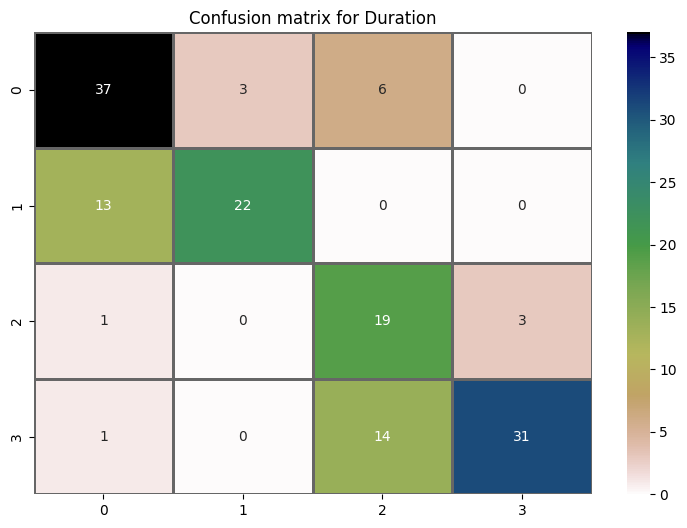

Classification Report for Class:
              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000        30
           1     0.8065    0.8333    0.8197        30
           2     0.9667    0.9667    0.9667        30
           3     1.0000    1.0000    1.0000        30
           4     0.8621    0.8333    0.8475        30

    accuracy                         0.8867       150
   macro avg     0.8870    0.8867    0.8868       150
weighted avg     0.8870    0.8867    0.8868       150



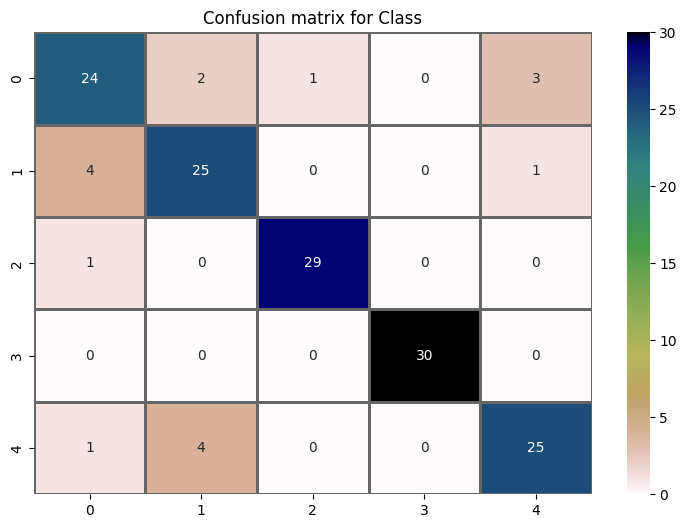

In [16]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# 对测试数据进行预测
pred = model.predict([testData, testmask])

# 计算每个输出的精度、召回率、F1得分和支持，并绘制混淆矩阵
outputs = ['Bandwidth', 'Duration', 'Class']
true_labels = [Y_test1, Y_test2, Y_test3]
for i in range(3):
    # 获取预测的标签
    predicted = np.argmax(pred[i], axis=1)
    expected = np.argmax(true_labels[i], axis=1)
    
    # 打印指标
    print(f'Classification Report for {outputs[i]}:')
    print(classification_report(expected, predicted, digits=4))

    # 绘制混淆矩阵
    cm = metrics.confusion_matrix(expected, predicted)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='0.6g', linewidths=1, cmap='gist_earth_r', linecolor='#666666')
    plt.title(f'Confusion matrix for {outputs[i]}')
    plt.show()

7.LSTM

In [17]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, multiply, LSTM
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.optimizers import Adam

timestep = 60
np.random.seed(10)

num_class = 5
train_sample_per_class = 20
lambda_value = 1


trainData = np.load("trainData.npy")
trainlabel = np.load("trainLabel.npy")
# trainData = trainData[:, -timestep*2:]
# trainlabel = trainlabel[:, -timestep*2:]
trainData = trainData[:, :timestep*2]
trainlabel = trainlabel[:, :timestep*2]
trainlabel = trainlabel.astype(int)

trainmask = np.zeros((trainlabel.shape[0],256))

class_counter = np.zeros((num_class))
train_size = trainlabel.shape[0]
j = 0
for i in range(train_size):
    class_id = trainlabel[i,2] - 1
    if class_counter[class_id] < train_sample_per_class:
        trainmask[i, :] = 1
        j += 1
        class_counter[class_id] += 1
print("unmasked samples: ", str(np.sum(trainmask==1)/256))


valData = np.load("valData.npy")
valLabel = np.load("valLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
valData = valData[:, :timestep*2]
valLabel = valLabel[:, :timestep*2]

valLabel = valLabel.astype(int)
valmask = np.ones((valLabel.shape[0], 256))
valmask[:,:]=1


testData = np.load("testData.npy")
testLabel = np.load("testLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
testData = testData[:, :timestep*2]
testLabel = testLabel[:, :timestep*2]

testLabel = testLabel.astype(int)
testmask = np.ones((testLabel.shape[0], 256))
testmask[:,:]=1

for i in range(trainlabel.shape[0]):
    #Categorizing Bandwidth
    if trainlabel[i, 0] < 10000:
        trainlabel[i, 0] = 1
    elif trainlabel[i, 0] < 50000:
        trainlabel[i, 0] = 2
    elif trainlabel[i, 0] < 100000:
        trainlabel[i, 0] = 3
    elif trainlabel[i, 0] < 1000000:
        trainlabel[i, 0] = 4
    else:
        trainlabel[i, 0] = 5
    #Categorizing Duration
    if trainlabel[i, 1] < 10:
        trainlabel[i, 1] = 1
    elif trainlabel[i, 1] < 30:
        trainlabel[i, 1] = 2
    elif trainlabel[i, 1] < 60:
        trainlabel[i, 1] = 3
    else:
        trainlabel[i, 1] = 4

for i in range(valLabel.shape[0]):
    #Categorizing Bandwidth
    if valLabel[i, 0] < 10000:
        valLabel[i, 0] = 1
    elif valLabel[i, 0] < 50000:
        valLabel[i, 0] = 2
    elif valLabel[i, 0] < 100000:
        valLabel[i, 0] = 3
    elif valLabel[i, 0] < 1000000:
        valLabel[i, 0] = 4
    else:
        valLabel[i, 0] = 5
    #Categorizing Duration
    if valLabel[i, 1] < 10:
        valLabel[i, 1] = 1
    elif valLabel[i, 1] < 30:
        valLabel[i, 1] = 2
    elif valLabel[i, 1] < 60:
        valLabel[i, 1] = 3
    else:
        valLabel[i, 1] = 4


for i in range(testLabel.shape[0]):
    #Categorizing Bandwidth
    if testLabel[i, 0] < 10000:
        testLabel[i, 0] = 1
    elif testLabel[i, 0] < 50000:
        testLabel[i, 0] = 2
    elif testLabel[i, 0] < 100000:
        testLabel[i, 0] = 3
    elif testLabel[i, 0] < 1000000:
        testLabel[i, 0] = 4
    else:
        testLabel[i, 0] = 5
    #Categorizing Duration
    if testLabel[i, 1] < 10:
        testLabel[i, 1] = 1
    elif testLabel[i, 1] < 30:
        testLabel[i, 1] = 2
    elif testLabel[i, 1] < 60:
        testLabel[i, 1] = 3
    else:
        testLabel[i, 1] = 4


train_size = trainlabel.shape[0]
Y_train1 = np.zeros((train_size,5))
Y_train1[np.arange(train_size),trainlabel[:,0]-1] = 1
Y_train2 = np.zeros((train_size,4))
Y_train2[np.arange(train_size),trainlabel[:,1]-1] = 1
Y_train3 = np.zeros((train_size,5))
Y_train3[np.arange(train_size),trainlabel[:,2]-1] = 1

val_size = valLabel.shape[0]
Y_val1 = np.zeros((val_size,5))
Y_val1[np.arange(val_size),valLabel[:,0]-1] = 1
Y_val2 = np.zeros((val_size,4))
Y_val2[np.arange(val_size),valLabel[:,1]-1] = 1
Y_val3 = np.zeros((val_size,5))
Y_val3[np.arange(val_size),valLabel[:,2]-1] = 1

test_size = testLabel.shape[0]
Y_test1 = np.zeros((test_size,5))
Y_test1[np.arange(test_size),testLabel[:,0]-1] = 1
Y_test2 = np.zeros((test_size,4))
Y_test2[np.arange(test_size),testLabel[:,1]-1] = 1
Y_test3 = np.zeros((test_size,5))
Y_test3[np.arange(test_size),testLabel[:,2]-1] = 1

# trainData = np.expand_dims(trainData, axis=-1)
# testData = np.expand_dims(testData, axis=-1)
trainData = trainData.reshape((trainData.shape[0], timestep, 2))
testData = testData.reshape((testData.shape[0], timestep, 2))
valData = valData.reshape((valData.shape[0], timestep, 2))

def base_model():

    model_input = Input(shape=(timestep,2))
    mask_input = Input(shape=(256,))

    x = LSTM(64, return_sequences=True)(model_input) # 使用LSTM替代Conv1D
    x = LSTM(64, return_sequences=False)(x) # 使用LSTM替代Conv1D

    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)

    output1 = Dense(5, activation='softmax', name='Bandwidth')(x)
    output2 = Dense(4, activation='softmax', name='Duration')(x)

    x3 = multiply([x,mask_input])
    output3 = Dense(5, activation='softmax', name='Class')(x3)

    model = Model(inputs=[model_input,mask_input], outputs=[output1, output2, output3])
    opt = Adam(clipnorm = 1.)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1,1,lambda_value], optimizer=opt, metrics=['accuracy'])

    return model

model = base_model()

model.fit([trainData,trainmask], [Y_train1, Y_train2, Y_train3],
          validation_data = ([valData, valmask], [Y_val1, Y_val2, Y_val3]),
          batch_size = 64, epochs = 20, verbose = True, shuffle = True)

result = model.evaluate([testData, testmask], [Y_test1, Y_test2, Y_test3])
print(result)

unmasked samples:  100.0
Epoch 1/20
96/96 [==============================] - 12s 76ms/step - loss: 4.1693 - Bandwidth_loss: 1.2886 - Duration_loss: 1.2839 - Class_loss: 1.5968 - Bandwidth_accuracy: 0.4968 - Duration_accuracy: 0.3590 - Class_accuracy: 0.3020 - val_loss: 4.1611 - val_Bandwidth_loss: 1.3269 - val_Duration_loss: 1.3582 - val_Class_loss: 1.4759 - val_Bandwidth_accuracy: 0.4400 - val_Duration_accuracy: 0.3667 - val_Class_accuracy: 0.2800
Epoch 2/20
96/96 [==============================] - 6s 61ms/step - loss: 3.9928 - Bandwidth_loss: 1.1947 - Duration_loss: 1.2210 - Class_loss: 1.5772 - Bandwidth_accuracy: 0.5336 - Duration_accuracy: 0.4014 - Class_accuracy: 0.3030 - val_loss: 4.0939 - val_Bandwidth_loss: 1.3056 - val_Duration_loss: 1.3201 - val_Class_loss: 1.4682 - val_Bandwidth_accuracy: 0.4400 - val_Duration_accuracy: 0.3333 - val_Class_accuracy: 0.2533
Epoch 3/20
96/96 [==============================] - 6s 62ms/step - loss: 3.7360 - Bandwidth_loss: 1.0696 - Duration_loss

5/5 [==============================] - 0s 8ms/step
Classification Report for Bandwidth:
              precision    recall  f1-score   support

           0     0.8667    0.8667    0.8667        30
           1     0.9643    1.0000    0.9818        27
           2     1.0000    0.6667    0.8000         3
           3     0.7377    0.8824    0.8036        51
           4     0.9310    0.6923    0.7941        39

    accuracy                         0.8467       150
   macro avg     0.8999    0.8216    0.8492       150
weighted avg     0.8598    0.8467    0.8457       150



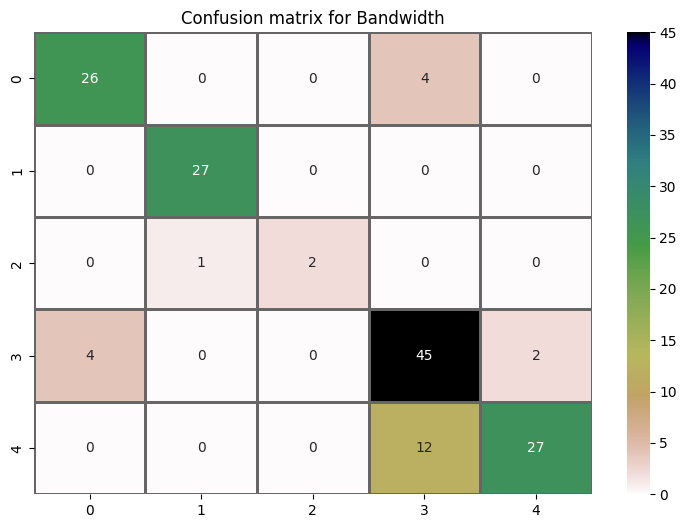

Classification Report for Duration:
              precision    recall  f1-score   support

           0     0.7447    0.7609    0.7527        46
           1     0.8846    0.6571    0.7541        35
           2     0.3514    0.5652    0.4333        23
           3     0.7750    0.6739    0.7209        46

    accuracy                         0.6800       150
   macro avg     0.6889    0.6643    0.6653       150
weighted avg     0.7263    0.6800    0.6943       150



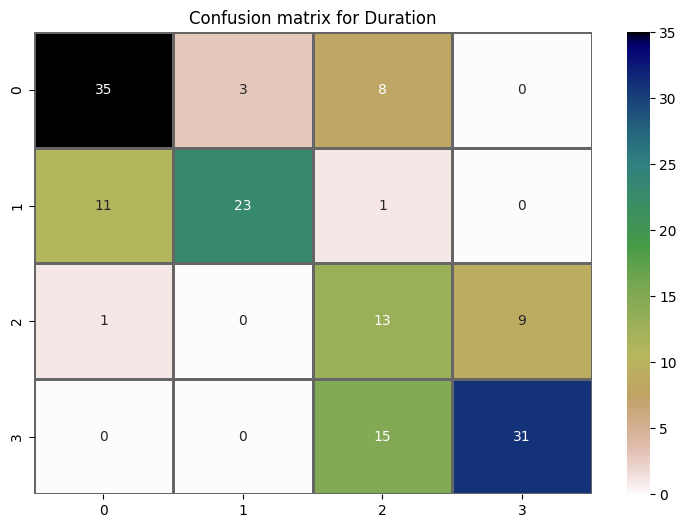

Classification Report for Class:
              precision    recall  f1-score   support

           0     0.7407    0.6667    0.7018        30
           1     0.7500    0.9000    0.8182        30
           2     0.8065    0.8333    0.8197        30
           3     1.0000    0.9333    0.9655        30
           4     0.9286    0.8667    0.8966        30

    accuracy                         0.8400       150
   macro avg     0.8452    0.8400    0.8403       150
weighted avg     0.8452    0.8400    0.8403       150



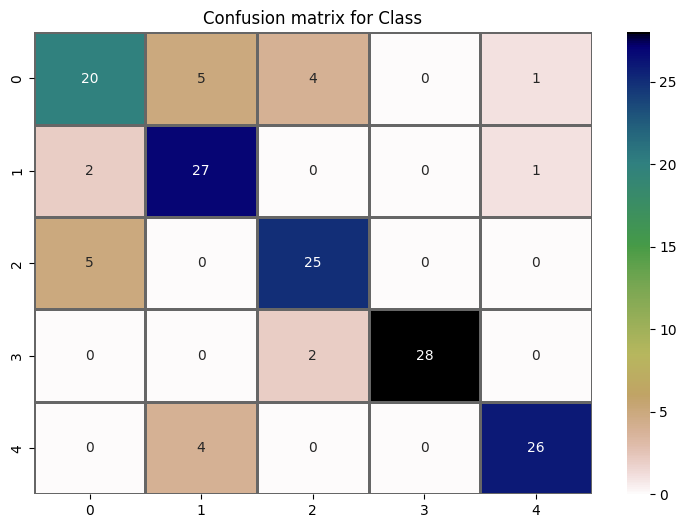

In [18]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# 对测试数据进行预测
pred = model.predict([testData, testmask])

# 计算每个输出的精度、召回率、F1得分和支持，并绘制混淆矩阵
outputs = ['Bandwidth', 'Duration', 'Class']
true_labels = [Y_test1, Y_test2, Y_test3]
for i in range(3):
    # 获取预测的标签
    predicted = np.argmax(pred[i], axis=1)
    expected = np.argmax(true_labels[i], axis=1)
    
    # 打印指标
    print(f'Classification Report for {outputs[i]}:')
    print(classification_report(expected, predicted, digits=4))

    # 绘制混淆矩阵
    cm = metrics.confusion_matrix(expected, predicted)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='0.6g', linewidths=1, cmap='gist_earth_r', linecolor='#666666')
    plt.title(f'Confusion matrix for {outputs[i]}')
    plt.show()